
ANALISI CONDOTTA CON LA FEATURE error rate (PASSATA A BOOLEAN OUTCOME)

In [95]:
from preprocessing_for_adult import preprocessing_funct_not_enc, encoding_funct, K_subgroups_dataset_and_or, metrics_to_compare,encoding_funct_SMOTE
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import torch

      
from divexplorer import DivergenceExplorer
from divexplorer import DivergencePatternProcessor       

In [96]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv("adult.data", header = None, names = col_names)

In [97]:
seed = 42
pd.options.display.float_format = '{:.3f}'.format


In [98]:
pruning = 0.03

In [99]:
min_sup = 0.1
percentage = 20

In [100]:
df_train, df_val, df_test, df_holdout = preprocessing_funct_not_enc(df)
#controllo divisione dataset
print(f"TRAIN SET ROWS: ", df_train.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout.shape[0])
print(f"TEST SET ROWS: ", df_test.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


In [101]:
df_train_enc, df_test_enc, df_holdout_enc, df_val_enc = encoding_funct(df_train=df_train, df_test=df_test, df_holdout=df_holdout, df_val=df_val)
#controllo coerenza con numerosità precedente
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val_enc.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout_enc.shape[0])
print(f"TEST SET ROWS: ", df_test_enc.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


In [102]:
#GDecisioN tree predictions
X_train = df_train_enc.drop(columns = 'income', axis = 1)
y_train = df_train_enc['income']

X_test = df_test_enc.drop(columns = 'income', axis = 1)
y_test = df_test_enc['income']

X_val = df_val_enc.drop(columns = 'income', axis = 1)
y_val = df_val_enc['income']

X_holdout = df_holdout_enc.drop(columns = 'income', axis = 1)
y_holdout = df_holdout_enc['income']

classifier_train = LogisticRegression(random_state=seed)
classifier_train.fit(X_train, y_train)
y_pred = classifier_train.predict(X_test)
cm_classifier = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_classifier, display_labels=[False, True])
#disp.plot()
#plt.show()

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [103]:
accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before = metrics_to_compare(y_true = y_test, y_pred = y_pred )
metrics_before_df = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_test)],
})
metrics_before_df = metrics_before_df.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Test Size']

for metric in metrics_to_cast:
    metrics_before_df[metric] = metrics_before_df[metric].astype(int)

metrics_before_df

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,6508


SUBGROUPS SEARCH

-Identifico i gruppi applicando DivExplorer sul validation not encoded (a cui ho aggiunto la feature sui falsi positivi da passare a boolean outcomes e la feature accuracy che vale 1 se la predizione è giusta e 0 se sbagliata )

-Integro nel training set dati che matchano sottogruppi problematici prendendoli dall'holdout, (primi K = 5, tutte le righe holdout che matchano)

-Ripeto training e test

In [104]:
#predizioni per il validation set
y_pred_val_dt = classifier_train.predict(X_val)

df_val_class = X_val.copy()
df_val_class['y_val_true'] = y_val
df_val_class['y_pred'] = y_pred_val_dt

df_val_class.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,age_group,edu_num_group,hours_per_week_group,y_val_true,y_pred
18761,2,0.077,3,0,4,1,4,0,0.000,0.000,5,2,1,1,0,0
27582,3,0.048,3,1,4,0,4,1,0.000,0.000,5,5,1,2,1,0
30911,2,0.174,3,3,4,4,2,0,0.039,0.000,5,1,1,1,0,0
11128,0,0.012,2,1,2,0,2,1,0.000,0.507,5,3,4,1,1,1
683,0,0.284,3,3,2,4,2,1,0.000,0.000,5,0,1,1,0,0


In [105]:
y_trues = df_val_class["y_val_true"]
y_preds = df_val_class["y_pred"]

In [106]:
#aggiungo la feature accuracy a df_val non encoded che assume valore 1 se la predizione è giusta 0 se la predizione è sbagliata
#come controllo che sia corretto aggiungo la feature y_pred 
df_val['y_pred'] = df_val_class['y_pred'] 
df_val['error'] = (df_val_class['y_val_true'] != df_val_class['y_pred']).astype(int)
df_val.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,income,age_group,edu_num_group,hours_per_week_group,y_pred,error
18761,Private,0.077,Non Graduated,Divorced,Self-emp-occ,Not-in-family,White,Female,0.000,0.000,United-States,0,35-44,10 College,Overtime,0,0
27582,Self-emp,0.048,Non Graduated,Married,Self-emp-occ,Husband,White,Male,0.000,0.000,United-States,1,65-100,10 College,Part-time,0,1
30911,Private,0.174,Non Graduated,Separated,Self-emp-occ,Unmarried,Black,Female,0.039,0.000,United-States,0,25-34,10 College,Overtime,0,0
11128,Government,0.012,Master's Degree,Married,Private-occ,Husband,Black,Male,0.000,0.507,United-States,1,45-54,14 Master's Degree,Overtime,1,0
683,Government,0.284,Non Graduated,Separated,Private-occ,Unmarried,Black,Male,0.000,0.000,United-States,0,17-24,10 College,Overtime,0,0


In [107]:
error_diver = DivergenceExplorer(df_val)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = error_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by=["error_div", "error_t"], ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
FP_fm.head()

,support,itemset,error,error_div,error_t,length,support_count
0,0.101,"(capital-gain=0.0, marital-status=Married, education=Bachelor's Degree)",0.464,0.265,13.239,3,659.000
1,0.102,"(capital-loss=0.0, capital-gain=0.0, hours_per_week_group=Overtime, occupation=Private-occ, marital-status=Married)",0.449,0.250,12.564,5,663.000
2,0.102,"(native-country=United-States, capital-gain=0.0, occupation=Private-occ, hours_per_week_group=Overtime, marital-status=Married)",0.449,0.250,12.564,5,663.000
3,0.102,"(capital-gain=0.0, hours_per_week_group=Overtime, occupation=Private-occ, marital-status=Married, race= White)",0.446,0.247,12.420,5,663.000
4,0.104,"(native-country=United-States, capital-loss=0.0, hours_per_week_group=Overtime, occupation=Private-occ, marital-status=Married, race= White)",0.444,0.244,12.405,6,676.000


In [108]:
#pruning 
error_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = error_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values("error_div", ascending=False)
df_pruned_error.head()

,support,itemset,length,support_count,error,error_div,error_t
0,0.101,"(capital-gain=0.0, marital-status=Married, education=Bachelor's Degree)",3,659.000,0.464,0.265,13.239
29,0.118,"(marital-status=Married, education=Bachelor's Degree)",2,768.000,0.428,0.229,12.380
144,0.120,"(marital-status=Married, age_group=45-54)",2,781.000,0.405,0.205,11.269
163,0.107,"(relationship= Husband, age_group=45-54)",2,695.000,0.401,0.202,10.526
195,0.143,"(marital-status=Married, age_group=35-44)",2,932.000,0.399,0.200,11.917


In [109]:
# Numero totale di istanze
total_instances = len(df_pruned_error)

# Numero di istanze con fp_div > 0 e fp_t > 2
filtered_instances = len(df_pruned_error[(df_pruned_error['error_div'] > 0) & (df_pruned_error['error_t'] > 2)])

print('total subgroups', total_instances)
print('total problematic', filtered_instances)

total subgroups 67
total problematic 38


In [110]:
prun_size = df_pruned_error.shape
original_size = FP_fm.shape
print("Dim original: ", original_size)
print("Dim pruned th_redundancy ", prun_size)

Dim original:  (3793, 7)
Dim pruned th_redundancy  (67, 7)


In [111]:
K = int((percentage / 100) * filtered_instances)
K

7

BIAS MITIGATION

BIAS MITIGATION: ADDING DATA: prendo dati dall'hold-out e li aggiungo al train set, questi dati matchano gli itemset trovati prima (i primi 5)

1. prendo dati dall'holdout con la funzione K_subgroups_dataset_and_or li aggiungo train 
2. riapplico encoding tutto
3. Decision tree nuovamente e vedo come sono cambiate le performance (ad es Accuracy, false positive rate, false negative rate) overall e per sottogruppi

In [112]:
df_holdout_filtered = K_subgroups_dataset_and_or(df_pruned_error, df_holdout, K) #da aggiungere a train set e ripetere train e test

df_combinated = pd.concat([df_holdout_filtered, df_train], ignore_index=True)
df_train_mitigated= df_combinated.sample(frac=1, random_state=seed).reset_index(drop=True)


In [113]:
print(len(df_holdout_filtered))

2341


In [114]:
#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati 
df_train_enc_mit, inutile1, inutile3, inutile2 = encoding_funct(df_train=df_train_mitigated, df_test=df_test, df_holdout=df_holdout_filtered, df_val=df_val)
#controllo divisione dataset
df_train_enc_mit_fp = df_train_enc_mit  
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0])
print(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", inutile1.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"FILTERED DF holdout ROWS: ", inutile3.shape[0])
print(f"TEST SET FILTERED ROWS: ", inutile2.shape[0])

TRAIN SET ROWS:  13014
TRAIN SET MITIGATED ROWS:  15355
VALIDATION SET ROWS:  6508
FILTERED DF holdout ROWS:  2341
TEST SET FILTERED ROWS:  6507


In [115]:
X_train_mitigated = df_train_enc_mit.drop(columns = 'income', axis = 1)
y_train_mitigated = df_train_enc_mit['income']


classifier_train_mitigated = LogisticRegression(random_state=seed)

classifier_train_mitigated.fit(X_train_mitigated, y_train_mitigated)
y_mitigated_pred = classifier_train_mitigated.predict(X_test)
#cm_dt = confusion_matrix(y_test, y_mitigated_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[False, True])
#disp.plot()

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [116]:
#per veriicare cosa accade se aggiungo in modo randomico lo stesso numero di righe al train, ripeto l'analisi facebdo mitigation con righe randomiche (uguali in numero)
print(len(df_holdout_filtered))
n = len(df_holdout_filtered)
df_holdout_sampled = df_holdout_enc.sample(n=len(df_holdout_filtered), replace=True, random_state=seed)
print("verifica :", len(df_holdout_sampled)) #verifica



df_combinated_random = pd.concat([df_holdout_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random= df_combinated_random.sample(frac=1, random_state=seed).reset_index(drop=True)

X_train_mitigated_random = df_train_mitigated_random.drop(columns="income", axis = 1)
y_train_mitigated_random = df_train_mitigated_random['income']

classifier_train_mitigated_random = LogisticRegression(random_state=seed)

classifier_train_mitigated_random.fit(X_train_mitigated_random, y_train_mitigated_random)
y_mitigated_pred_random = classifier_train_mitigated_random.predict(X_test)



2341
verifica : 2341


/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [117]:
accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred )
accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random= metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random)

metrics_after_fp = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After Mitigation(K=5, fp)': [accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after, len(y_train_mitigated), len(y_test)],
    'After RANDOM mitigation' : [accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random, len(y_train_mitigated_random), len(y_test)]
})
metrics_after_fp = metrics_after_fp.set_index('Metrics').T



metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp[metric] = metrics_after_fp[metric].astype(int)

metrics_after_fp

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,13014,6508
"After Mitigation(K=5, fp)",0.806,0.491,0.062,0.611,305,958,15355,6508
After RANDOM mitigation,0.809,0.478,0.050,0.637,245,999,15355,6508


Performance su sottogruppi 

In [118]:
df_test_filtered_fp = K_subgroups_dataset_and_or(df_pruned_error, df_test, K)
inutile, df_test_filtered_enc_fp, inutile2, inutile3 = encoding_funct(df_train, df_test_filtered_fp, df_holdout, df_val)

X_test_filtered_fp = df_test_filtered_enc_fp.drop(columns='income', axis = 1)
y_true_test_filtered_fp = df_test_filtered_enc_fp['income']

y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after = classifier_train_mitigated.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_random = classifier_train_mitigated_random.predict(X_test_filtered_fp)

accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after )
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_random)


metrics_after_fp_sottogruppi = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after, len(y_train_mitigated), len(y_pred_test_filtered_fp_after)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(y_train_mitigated_random), len(y_pred_test_filtered_fp_after_random)]
})
metrics_after_fp_sottogruppi = metrics_after_fp_sottogruppi.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi[metric] = metrics_after_fp_sottogruppi[metric].astype(int)

metrics_after_fp


print("Subgroups Decision Tree performance when boolean outcomes = fp")
metrics_after_fp_sottogruppi

Subgroups Decision Tree performance when boolean outcomes = fp


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.627,0.507,0.127,0.617,147,723,13014,2330
"After Mitigation(K=5, on subgroups, fp)",0.633,0.530,0.142,0.588,165,689,15355,2330
"After RANDOM Mitigation(K=5, on subgroups, fp)",0.628,0.512,0.129,0.612,149,717,15355,2330


ANALISI DIVERGENZE


Per vedere cosa accade ai sottogruppi: vedo cosa succede alle divergenze del test dopo la mitigation

In [119]:
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]


df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values("error_div", ascending=False)
df_pruned_error.head()



error_div_list_no_mitigation  = df_pruned_error["error_div"].tolist()
#error_div_list_no_mitigation

#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred 

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]


df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values("error_div", ascending=False)
df_pruned_error.head()



error_div_list_baseline1  = df_pruned_error["error_div"].tolist()
#error_div_list_baseline1

#PER VEDERE COSA SUCCEDE ALLE DIVERGENZE DEI SOTTOGRUPPI CON MITIGATION RADOMICA
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by="error_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values("error_div", ascending=False)
df_pruned_error.head()



error_div_list_random_per_confrontare_con_baseline1  = df_pruned_error["error_div"].tolist()
#error_div_list_random_per_confrontare_con_baseline1

# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_error_div_list_no_mitigation = np.nanmean(error_div_list_no_mitigation)
media_error_div_list_nomitigation_primi10 = np.nanmean(error_div_list_no_mitigation[:10])
media_error_div_list_nomitigation_primi20 = np.nanmean(error_div_list_no_mitigation[:20])
media_error_div_list_nomitigation_primi40 = np.nanmean(error_div_list_no_mitigation[:40])
massimo_valore_assoluto_error_div_no_mitigation = max(abs(x) for x in error_div_list_no_mitigation)

media_error_div_list_baseline1 = np.nanmean(error_div_list_baseline1)
media_error_div_list_baseline1_primi10 = np.nanmean(error_div_list_baseline1[:10])
media_error_div_list_baseline1_primi20 = np.nanmean(error_div_list_baseline1[:20])
media_error_div_list_baseline1_primi40 = np.nanmean(error_div_list_baseline1[:40])
error_div_massimo_valore_assoluto_error_div_baseline1 = max(abs(x) for x in error_div_list_baseline1)

media_error_div_list_random_per_confrontare_con_baseline1 = np.nanmean(error_div_list_random_per_confrontare_con_baseline1)
media_error_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(error_div_list_random_per_confrontare_con_baseline1[:10])
media_error_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(error_div_list_random_per_confrontare_con_baseline1[:20])
media_error_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(error_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_error_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in error_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_correctness_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_error_div_list_no_mitigation, massimo_valore_assoluto_error_div_no_mitigation,
        media_error_div_list_nomitigation_primi10, media_error_div_list_nomitigation_primi20, media_error_div_list_nomitigation_primi40, 0
    ],
    'After Mitigation(K=5 fp)': [
        accuracy_fp_after, f1_score_fp_after, media_error_div_list_baseline1, error_div_massimo_valore_assoluto_error_div_baseline1,
        media_error_div_list_baseline1_primi10, media_error_div_list_baseline1_primi20, media_error_div_list_baseline1_primi40, len(df_holdout_filtered)
    ],
    'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_error_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_error_div_random_per_confrontare_con_baseline1, media_error_div_list_random_per_confrontare_con_baseline1_primi10,
        media_error_div_list_random_per_confrontare_con_baseline1_primi20, media_error_div_list_random_per_confrontare_con_baseline1_primi40,
        len(df_holdout_filtered)
    ]
})

# Trasposizione per visualizzazione
divergence_after_correctness_sottogruppi = divergence_after_correctness_sottogruppi.set_index('Metrics').T

divergence_after_correctness_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.040,0.245,0.206,0.166,0.115,0.000
After Mitigation(K=5 fp),0.806,0.491,0.036,0.235,0.198,0.157,0.106,2341.000
After RANDOM Mitigation(K=5 fp),0.809,0.478,0.036,0.241,0.204,0.161,0.109,2341.000


BIAS MITIGATION SIMULANDO DATI ATTRAVERSO SMOTE

SEGUE CODICE USANDO SMOTE 
DIVIDO IN TRAIN, TEST E VALIDATION -- ora uso quelli gia esistenti
DIV EXPLORER SUL VALIDATION  -- già fatto 
GENERO NUOVI DATI CON SMOTE a partire dai dati di divexplorer sul validation
INSERISCO QUESTI NUOVI DATI NEL TRAIN SET

In [120]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_error, df_val, K)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = ['error', 'y_pred', 'income'], axis = 1)
y_to_SMOTE = df_val_filtered['income']
X_to_SMOTE.head()

categorical_features = [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

smote_nc = SMOTENC( categorical_features=categorical_features, random_state=seed)
X_resampled, y_resampled = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)

print("numero di dati simulati con smotenc",len(y_resampled))

class_counts = y_resampled.value_counts()
print(class_counts)




Righe del dataset filtrato qunado K = 5 1866
numero di dati simulati con smotenc 1880
income
1    940
0    940
Name: count, dtype: int64


In [121]:
X_train_mitigated_SMOTE = pd.concat([X_train, X_resampled], ignore_index=True)
y_train_mitigated_SMOTE = pd.concat([y_train, y_resampled], ignore_index=True)
print(len(X_train_mitigated_SMOTE))

14894


In [122]:
classifier_train_mitigated_SMOTE = LogisticRegression(random_state=seed)
classifier_train_mitigated_SMOTE.fit(X_train_mitigated_SMOTE, y_train_mitigated_SMOTE)
y_mitigated_SMOTE_pred = classifier_train_mitigated_SMOTE.predict(X_test)

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [123]:
'''#vediamo che succede se prendo lo stesso numero di righe ma random da holdout
print(len(X_resampled))
n_random_smote = len(X_resampled)

df_holdout_smote_sampled = df_holdout_enc.sample(n=n_random_smote, random_state=seed)
print("verifica :", len(df_holdout_smote_sampled)) #verifica

df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)

X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote = LogisticRegression(random_state=seed)

classifier_train_mitigated_random_smote.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote = classifier_train_mitigated_random_smote.predict(X_test)

'''



'#vediamo che succede se prendo lo stesso numero di righe ma random da holdout\nprint(len(X_resampled))\nn_random_smote = len(X_resampled)\n\ndf_holdout_smote_sampled = df_holdout_enc.sample(n=n_random_smote, random_state=seed)\nprint("verifica :", len(df_holdout_smote_sampled)) #verifica\n\ndf_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)\ndf_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)\n\nX_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)\ny_train_mitigated_random_smote = df_train_mitigated_random_smote[\'income\']\n\nclassifier_train_mitigated_random_smote = LogisticRegression(random_state=seed)\n\nclassifier_train_mitigated_random_smote.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)\ny_mitigated_pred_random_smote = classifier_train_mitigated_random_smote.predict(X_test)\n\n'

In [124]:
'''accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_SMOTE_pred )
accuracy_fp_after_SMOTE_random, f1_score_fp_after_SMOTE_random, fpr_fp_after_SMOTE_random, fnr_fp_after_SMOTE_random, fp_fp_after_SMOTE_random, fn_fp_after_SMOTE_random = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote )


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After SMOTE fp mitigation' : [accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_mitigated_SMOTE_pred)],
    'After RANDOM mitigation' : [accuracy_fp_after_SMOTE_random, f1_score_fp_after_SMOTE_random, fpr_fp_after_SMOTE_random, fnr_fp_after_SMOTE_random, fp_fp_after_SMOTE_random, fn_fp_after_SMOTE_random, len(y_train_mitigated_random_smote), len(y_mitigated_pred_random_smote)]
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)
    
metrics_after_fp_SMOTE'''


"accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_SMOTE_pred )\naccuracy_fp_after_SMOTE_random, f1_score_fp_after_SMOTE_random, fpr_fp_after_SMOTE_random, fnr_fp_after_SMOTE_random, fp_fp_after_SMOTE_random, fn_fp_after_SMOTE_random = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote )\n\n\nmetrics_after_fp_SMOTE = pd.DataFrame({\n    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],\n    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],\n    'After SMOTE fp mitigation' : [accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_mitigated_SMOTE_

A QUESTO PUNTO POSSIAMO VEDERE LE PERFORMANCE SUI SOTTOGRUPPI PRIMA E DOPO 

In [125]:
'''# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
y_pred_test_filtered_fp_after_SMOTE = classifier_train_mitigated_SMOTE.predict(X_test_filtered_fp)
y_pred_RANDOM_subgroups = classifier_train_mitigated_random_smote.predict(X_test_filtered_fp)


#accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE )
accuracy_fp_sottogruppi_random_SMOTE, f1_score_fp_sottogruppi_random_SMOTE, fpr_fp_sottogruppi_random_SMOTE, fnr_fp_sottogruppi_random_SMOTE, fp_fp_sottogruppi_random_SMOTE, fn_fp_sottogruppi_random_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_RANDOM_subgroups )

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM mitigation, on subgroups' : [accuracy_fp_sottogruppi_random_SMOTE, f1_score_fp_sottogruppi_random_SMOTE, fpr_fp_sottogruppi_random_SMOTE, fnr_fp_sottogruppi_random_SMOTE, fp_fp_sottogruppi_random_SMOTE, fn_fp_sottogruppi_random_SMOTE, len(y_train), len(y_pred_RANDOM_subgroups)],
    'After Mitigation(K=5, on subgroups, fp and SMOTE)': [accuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_pred_test_filtered_fp_after_SMOTE)],
})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE


print("Subgroups Decision Tree performance when boolean outcomes = correctness e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE'''

'# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima \ny_pred_test_filtered_fp_after_SMOTE = classifier_train_mitigated_SMOTE.predict(X_test_filtered_fp)\ny_pred_RANDOM_subgroups = classifier_train_mitigated_random_smote.predict(X_test_filtered_fp)\n\n\n#accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )\naccuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE )\naccuracy_fp_sottogruppi_random_SMOTE, f1_score_fp_sottogruppi_random_SMOTE, fpr_fp_sottogruppi_random_SMOTE, fnr_fp_sottogruppi_random

BIAS MITIGATION SMOTENC

- FISSO N VARIA p, p è la probabilità che il campione simulato sia di classe 0 qui (perchè voglio diminuire il numero di falsi positivi)
- FISSO p VARIA N 

In [126]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_error, df_val, K)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = [ 'y_pred', 'error', 'income'], axis = 1)
y_to_SMOTE = df_val_filtered['income']
X_to_SMOTE.head()

categorical_features = [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

Righe del dataset filtrato qunado K = 5 1866


In [127]:
count_1 = df_val_filtered['income'].sum()
count_0 = len(df_val_filtered) - count_1
count_1, count_0

(940, 926)

per confronto con targeted
N come len_df_holdout_filtered

In [128]:
p0=0
p1 = 0.1
p2 = 0.2
p3 = 0.3 
p4 = 0.4
p5 = 0.5
p6 = 0.6
p7 = 0.7
p8 = 0.8
p9 = 0.9
p10 = 1

In [129]:
N = len(df_holdout_filtered)

In [130]:
#0
N = len(df_holdout_filtered)
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_2K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.040,0.245,0.206,0.166,0.115,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.478,0.036,0.241,0.204,0.161,0.109,2341.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.799,0.549,0.031,0.224,0.161,0.128,0.066,2341.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.806,0.498,0.031,0.236,0.183,0.145,0.095,2341.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.806,0.430,0.051,0.262,0.226,0.189,0.131,2341.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.801,0.368,0.050,0.286,0.240,0.195,0.137,2341.000


N = 2000

In [131]:
#0
N = 2000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_2K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.040,0.245,0.206,0.166,0.115,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.478,0.034,0.242,0.202,0.158,0.105,2000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.803,0.547,0.030,0.216,0.152,0.123,0.074,2000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.806,0.495,0.030,0.240,0.185,0.146,0.095,2000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.806,0.435,0.049,0.261,0.225,0.187,0.130,2000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.801,0.378,0.049,0.280,0.236,0.191,0.134,2000.000


In [132]:
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,13014,6508
After RANDOM mitigation N = 5000,0.808,0.474,0.050,0.641,246,1005,15014,6508
After SMOTE N = 5000 p_class 0 = 0,0.799,0.567,0.122,0.452,601,709,15014,6508
After SMOTE N = 5000 p_class 0 = 0.1,0.801,0.560,0.113,0.473,556,742,15014,6508
After SMOTE N = 5000 p_class 0 = 0.2,0.803,0.547,0.099,0.506,491,793,15014,6508
After SMOTE N = 5000 p_class 0 = 0.3,0.808,0.545,0.087,0.523,431,820,15014,6508
After SMOTE N = 5000 p_class 0 = 0.4,0.809,0.530,0.077,0.552,378,866,15014,6508
After SMOTE N = 5000 p_class 0 = 0.5,0.806,0.495,0.064,0.605,316,948,15014,6508
After SMOTE N = 5000 p_class 0 = 0.6,0.806,0.474,0.053,0.638,263,1000,15014,6508
After SMOTE N = 5000 p_class 0 = 0.7,0.808,0.461,0.044,0.659,217,1034,15014,6508


N = 3000

In [133]:
#0
N = 3000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_3K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.040,0.245,0.206,0.166,0.115,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.478,0.043,0.244,0.204,0.164,0.113,3000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.798,0.563,0.031,0.211,0.140,0.113,0.060,3000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.807,0.511,0.031,0.227,0.185,0.148,0.102,3000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.804,0.415,0.055,0.275,0.237,0.198,0.138,3000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.798,0.347,0.051,0.296,0.242,0.199,0.140,3000.000


N = 4000

In [134]:
#0
N = 4000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_4K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.040,0.245,0.206,0.166,0.115,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.478,0.035,0.237,0.200,0.158,0.105,4000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.794,0.571,0.033,0.216,0.130,0.103,0.044,4000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.807,0.518,0.033,0.218,0.179,0.147,0.103,4000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.801,0.401,0.056,0.283,0.244,0.208,0.146,4000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.795,0.318,0.053,0.320,0.254,0.209,0.148,4000.000


N = 5000 p changes

In [135]:
#0
N = 5000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_5K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.040,0.245,0.206,0.166,0.115,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.478,0.040,0.248,0.204,0.165,0.113,5000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.789,0.578,0.011,0.214,0.129,0.103,0.047,5000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.802,0.526,0.011,0.205,0.145,0.117,0.063,5000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.801,0.394,0.054,0.286,0.241,0.203,0.141,5000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.793,0.301,0.053,0.291,0.248,0.207,0.147,5000.000


In [136]:
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,13014,6508
After RANDOM mitigation N = 5000,0.808,0.480,0.052,0.633,258,992,18014,6508
After SMOTE N = 5000 p_class 0 = 0,0.762,0.582,0.215,0.311,1062,488,18014,6508
After SMOTE N = 5000 p_class 0 = 0.1,0.780,0.579,0.171,0.374,844,586,18014,6508
After SMOTE N = 5000 p_class 0 = 0.2,0.789,0.578,0.150,0.401,742,629,18014,6508
After SMOTE N = 5000 p_class 0 = 0.3,0.798,0.569,0.124,0.447,612,701,18014,6508
After SMOTE N = 5000 p_class 0 = 0.4,0.802,0.548,0.102,0.502,503,787,18014,6508
After SMOTE N = 5000 p_class 0 = 0.5,0.802,0.526,0.089,0.543,438,852,18014,6508
After SMOTE N = 5000 p_class 0 = 0.6,0.806,0.481,0.057,0.627,280,983,18014,6508
After SMOTE N = 5000 p_class 0 = 0.7,0.805,0.444,0.043,0.677,210,1061,18014,6508


N = 6000 p changes

In [137]:
#0
N = 6000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_6K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.040,0.245,0.206,0.166,0.115,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.478,0.036,0.241,0.200,0.158,0.107,6000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.783,0.577,0.019,0.211,0.122,0.099,0.039,6000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.801,0.520,0.019,0.201,0.158,0.126,0.077,6000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.802,0.406,0.053,0.283,0.239,0.196,0.138,6000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.792,0.280,0.056,0.299,0.264,0.221,0.157,6000.000


In [138]:
#0
N = 7000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_6K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.040,0.245,0.206,0.166,0.115,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.478,0.039,0.243,0.208,0.166,0.114,7000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.777,0.575,0.017,0.213,0.123,0.098,0.032,7000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.802,0.531,0.017,0.198,0.154,0.123,0.071,7000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.800,0.386,0.054,0.288,0.244,0.205,0.144,7000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.790,0.267,0.060,0.308,0.271,0.229,0.166,7000.000


In [139]:
#0
N = 8000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_6K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.040,0.245,0.206,0.166,0.115,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.478,0.037,0.241,0.206,0.162,0.109,8000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.771,0.573,0.012,0.219,0.118,0.095,0.028,8000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.803,0.541,0.012,0.199,0.145,0.116,0.059,8000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.799,0.384,0.053,0.289,0.240,0.199,0.139,8000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.790,0.263,0.060,0.311,0.273,0.231,0.167,8000.000


In [140]:
#0
N = 9000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*p0), 1: count_1 + int(N*p10)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p0 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p0 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p0 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p0.fit(X_train_mit_SMOTE_p0, y_train_mit_SMOTE_p0)
y_pred_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test)

#0.1
sampling_strategy = {0: count_0 + int(N*p1), 1: count_1 + int(N*p9)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)


#0.2
sampling_strategy = {0: count_0 + int(N*p2), 1: count_1 + int(N*p8)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#0.3
sampling_strategy = {0: count_0 + int(N*p3), 1: count_1 + int(N*p7)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)


#0.4
sampling_strategy = {0: count_0 + int(N*p4), 1: count_1 + int(N*p6)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)



#0.5
sampling_strategy = {0: count_0 + int(N*p5), 1: count_1 + int(N*p5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)





#0.6
sampling_strategy = {0: count_0 + int(N*p6), 1: count_1 + int(N*p4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#0.7
sampling_strategy = {0: count_0 + int(N*p7), 1: count_1 + int(N*p3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p7 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p7 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p7 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p7.fit(X_train_mit_SMOTE_p7, y_train_mit_SMOTE_p7)
y_pred_SMOTE_p7= classifier_train_mit_SMOTE_p7.predict(X_test)




#0.8
sampling_strategy = {0: count_0 + int(N*p8), 1: count_1 + int(N*p2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p8 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p8 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p8 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p8.fit(X_train_mit_SMOTE_p8, y_train_mit_SMOTE_p8)
y_pred_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test)




#0.9
sampling_strategy = {0: count_0 + int(N*p9), 1: count_1 + int(N*p1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p9 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p9 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p9 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p9.fit(X_train_mit_SMOTE_p9, y_train_mit_SMOTE_p9)
y_pred_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test)





#1
sampling_strategy = {0: count_0 + int(N*p10), 1: count_1 + int(N*p0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p10 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p10 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p10 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p10.fit(X_train_mit_SMOTE_p10, y_train_mit_SMOTE_p10)
y_pred_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test)








#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
    
accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p0 )    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )
accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p7 )
accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p8 )
accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p9 )
accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p10 )



accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0' : [accuracy_fp_after_SMOTE_p0, f1_score_fp_after_SMOTE_p0, fpr_fp_after_SMOTE_p0, fnr_fp_after_SMOTE_p0, fp_fp_after_SMOTE_p0, fn_fp_after_SMOTE_p0, len(X_train_mit_SMOTE_p0), len(y_pred_SMOTE_p0)] ,
    'After SMOTE N = 5000 p_class 0 = 0.1' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.2' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.3' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.4' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p7, f1_score_fp_after_SMOTE_p7, fpr_fp_after_SMOTE_p7, fnr_fp_after_SMOTE_p7, fp_fp_after_SMOTE_p7, fn_fp_after_SMOTE_p7, len(X_train_mit_SMOTE_p7), len(y_pred_SMOTE_p7)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p8, f1_score_fp_after_SMOTE_p8, fpr_fp_after_SMOTE_p8, fnr_fp_after_SMOTE_p8, fp_fp_after_SMOTE_p8, fn_fp_after_SMOTE_p8, len(X_train_mit_SMOTE_p8), len(y_pred_SMOTE_p8)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p9, f1_score_fp_after_SMOTE_p9, fpr_fp_after_SMOTE_p9, fnr_fp_after_SMOTE_p9, fp_fp_after_SMOTE_p9, fn_fp_after_SMOTE_p9, len(X_train_mit_SMOTE_p9), len(y_pred_SMOTE_p9)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p10, f1_score_fp_after_SMOTE_p10, fpr_fp_after_SMOTE_p10, fnr_fp_after_SMOTE_p10, fp_fp_after_SMOTE_p10, fn_fp_after_SMOTE_p10, len(X_train_mit_SMOTE_p10), len(y_pred_SMOTE_p10)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


errors_after_6K = [fp + fn for fp, fn in zip(falsi_positivi_2K_fp_5sub, falsi_negativi_2K_fp_5sub)]
errors_before = falsi_negativi_2K_fp_5sub_before + falsi_positivi_2K_fp_5sub_before 

accuracy02 = metrics_after_fp_SMOTE['Accuracy'].iloc[4]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[10]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[12]

f1score02 = metrics_after_fp_SMOTE['F1 Score'].iloc[4]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[10]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[12]
#SOTTOGRUPPI
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p0 = classifier_train_mit_SMOTE_p0.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p7 = classifier_train_mit_SMOTE_p7.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p8 = classifier_train_mit_SMOTE_p8.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p9 = classifier_train_mit_SMOTE_p9.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p10 = classifier_train_mit_SMOTE_p10.predict(X_test_filtered_fp)



#non ci importa dei sttogruppi 
accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 



df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_no_mitigation  = df_pruned_error['error_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.2

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p2

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p2_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K






#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p5

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p5_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p8

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p8_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p10

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_baseline2_p10_5K = df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['error'] = (y_trues != y_preds).astype(int)

#aggiungo la feature 'error' a df_val non encoded
df_test['error'] = df_test_class['error']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['error'])
FP_fm = FP_fm.sort_values(by='error_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'error')
df_pruned_error = fp_details.redundancy_pruning(th_redundancy=pruning)
df_pruned_error = df_pruned_error.sort_values('error_div', ascending=False)
df_pruned_error.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_error['error_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p2_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p2_5K_primi10 = np.nanmean(fp_div_list_baseline2_p2_5K[:10])
media_fp_div_list_baseline2_p2_5K_primi20 = np.nanmean(fp_div_list_baseline2_p2_5K[:20])
media_fp_div_list_baseline2_p2_5K_primi40 = np.nanmean(fp_div_list_baseline2_p2_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K = max(abs(x) for x in fp_div_list_baseline2_p2_5K)

media_fp_div_list_baseline2_p5_5K = np.nanmean(fp_div_list_baseline2_p5_5K)
media_fp_div_list_baseline2_p5_5K_primi10 = np.nanmean(fp_div_list_baseline2_p5_5K[:10])
media_fp_div_list_baseline2_p5_5K_primi20 = np.nanmean(fp_div_list_baseline2_p5_5K[:20])
media_fp_div_list_baseline2_p5_5K_primi40 = np.nanmean(fp_div_list_baseline2_p5_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K = max(abs(x) for x in fp_div_list_baseline2_p5_5K)


media_fp_div_list_baseline2_p8_5K = np.nanmean(fp_div_list_baseline2_p8_5K)
media_fp_div_list_baseline2_p8_5K_primi10 = abs(sum(fp_div_list_baseline2_p8_5K[:10]) / len(fp_div_list_baseline2_p8_5K[:10]))
media_fp_div_list_baseline2_p8_5K_primi20 = abs(sum(fp_div_list_baseline2_p8_5K[:20]) / len(fp_div_list_baseline2_p8_5K[:20]))
media_fp_div_list_baseline2_p8_5K_primi40 = abs(sum(fp_div_list_baseline2_p8_5K[:40]) / len(fp_div_list_baseline2_p8_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K = max(abs(x) for x in fp_div_list_baseline2_p8_5K)

media_fp_div_list_baseline2_p10_5K = np.nanmean(fp_div_list_baseline2_p10_5K)
media_fp_div_list_baseline2_p10_5K_primi10 = np.nanmean(fp_div_list_baseline2_p10_5K[:10])
media_fp_div_list_baseline2_p10_5K_primi20 = np.nanmean(fp_div_list_baseline2_p10_5K[:20])
media_fp_div_list_baseline2_p10_5K_primi40 = np.nanmean(fp_div_list_baseline2_p10_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K = max(abs(x) for x in fp_div_list_baseline2_p10_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=0.2)': [
        accuracy02, f1score02, media_fp_div_list_baseline2_p2_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p2_5K,
        media_fp_div_list_baseline2_p2_5K_primi10, media_fp_div_list_baseline2_p2_5K_primi20, media_fp_div_list_baseline2_p2_5K_primi40, N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p5_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p5_5K,
        media_fp_div_list_baseline2_p5_5K_primi10, media_fp_div_list_baseline2_p5_5K_primi20, media_fp_div_list_baseline2_p5_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p8_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p8_5K,
        media_fp_div_list_baseline2_p8_5K_primi10, media_fp_div_list_baseline2_p8_5K_primi20, media_fp_div_list_baseline2_p8_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p10_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p10_5K,
        media_fp_div_list_baseline2_p10_5K_primi10, media_fp_div_list_baseline2_p10_5K_primi20, media_fp_div_list_baseline2_p10_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.040,0.245,0.206,0.166,0.115,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.478,0.037,0.243,0.201,0.161,0.111,9000.000
"After Mitigation(K=5 fp, N = 5K, p=0.2)",0.768,0.577,0.009,0.222,0.119,0.095,0.033,9000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.800,0.532,0.009,0.197,0.138,0.110,0.055,9000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.798,0.367,0.055,0.298,0.245,0.206,0.147,9000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.790,0.260,0.060,0.312,0.275,0.231,0.165,9000.000


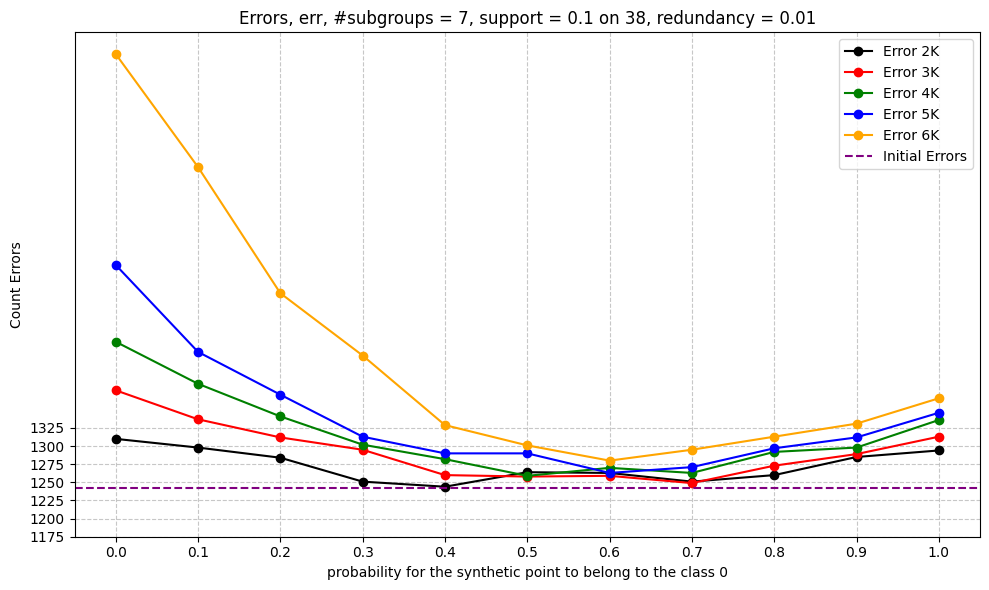

In [141]:
# Creazione del grafico
plt.figure(figsize=(10, 6))
p =[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Linea per i falsi positivi

plt.plot(p, errors_after_2K, marker='o', label='Error 2K ', color='black')
plt.plot(p, errors_after_3K, marker='o', label='Error 3K ', color='red')
plt.plot(p, errors_after_4K, marker='o', label='Error 4K ', color='green')
plt.plot(p, errors_after_5K, marker='o', label='Error 5K ', color='blue')
plt.plot(p, errors_after_6K,  marker='o', label='Error 6K ', color='orange')


plt.axhline(y=errors_before, color='purple', linestyle='--', label='Initial Errors')

# Etichette e titolo
plt.xlabel('probability for the synthetic point to belong to the class 0')
plt.ylabel('Count Errors')
plt.title(f'Errors, err, #subgroups = {K}, support = {min_sup} on {filtered_instances}, redundancy = 0.01')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()


plt.yticks(range(1175, 1350, 25))
plt.xticks(np.arange(0, 1.1, 0.1)) 
# Mostra il grafico
plt.tight_layout()
plt.show()

In [142]:
count_1, count_0

(940, 926)